# Entropy Pooling Portfolio Optimization
This Jupyter notebook and the associated Python files are intended for performing a Markovitz portfolio optimization using Entropy Pooling to incportporate information contained in user-specified return scenarios and views.

Credits: Lauri Jokinen, Christian Segercrantz and Ilmari Vauhkonen

### 1) Imports and setting parameters
The first step is to import all necessary packages and to specify all user-defined parameters.

In [1]:
import pandas as pd 
import numpy as np
import os

from plotnine import ggplot, geom_area, aes, labs, scale_x_continuous
from tqdm.notebook import tqdm 

# Import functions
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

In [2]:
### ALL PARAMETERS SPECIFIED BY USER ARE SET HERE ###

### Set the current working directory correctly
# directory = ''
# os.chdir(directory)

### Filenames (and sheet names if necessary) of the input Excel files
scenarios_file = 'data/data.xlsx'
views_file     = 'data/sample_portfolio2_views.xlsx'
views_sheet    = 2
deltas_file    = 'data/sample_portfolio2_deltas.xlsx'
constrs_file   = 'data/sample_portfolio2_constrs.xlsx'

### Other parameters to be defined by the user
confidence_weight = 1 # between [0,1], how big a 'compromise' is done betw. prior and posterior distributions
total_capital     = 417000000 # The total (net) amount of capital that is invested in the portfolio.
mu_0              = 0.0005 * total_capital # The minimum expected return of the portfolio (in Euros)
c                 = 1 #Probability of the posterior distribution happening
titles            = ['Rates up', 'Rates down', 'Eq up', 'Eq down', 'Inflation up', 'Inflation down', 'Vix up', 'Vix down'] #Give a name to each of the views, in the same order as the sheets appear in the views excel.
file_extension    = "png" #Choose what the file extension to save the plot as. Commonly used ones are PNG normal pictures and EPS for vektor 

### 2) Uploading user inputs
We proceed by uploading the input data: factor scenarios, views, asset delta matrix and optimization constraints.

In [3]:
# Scenarios and prior probabilities
scenarios, prior = markoviz_optimizer.load_factor_scenarios(scenarios_file, scale_by_100 = True)
# Views
(A,b,C,d) = views.load(views_sheet_name = views_file, views_subsheet_name = views_sheet);
# Asset deltas
deltas, asset_names = markoviz_optimizer.load_asset_deltas(deltas_file)
# Portfolio constraints
constr_A, lb, ub = markoviz_optimizer.load_portfolio_constraints(constrs_file)
manual_constraints = (constr_A, lb, ub)

### 3) Entropy minimization
Now we minimize the relative entropy between the given prior distribution and the posterior distribution, so that the view(s), expressed in terms of linear constraints, is (are) satisfied.

In [4]:
posterior = entropy_minimizer.full_confidence_posterior(prior, A, b, C, d, verbose = True)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(prior, posterior, c)

Results
Optimal dual variable values:  [ 2.81186418 -0.97813745]
Jacobian matrix at optimum [-3.06266828e-06 -4.02891634e-07]


### 4) Computing the asset-specific return scenarios
This is a necessary step so that we can formulate the expected returns and variance-covariance matrix needed for the Markowitz optimization.

In [5]:
asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

The optimization was succesful: True
Global Equities: 7098568.0
DM Equities: 7098570.0
EM Equities: 7098538.0
European Equities: 7098566.0
US Equities: 7098575.0
EUR Money Markets: 53253618.0
EUR Government Bonds: 86221436.0
EUR Covered Bonds: 53253596.0
EUR Investment Grade Corporate Bonds: 53253577.0
European High Yield Corporate Bonds: 41700000.0
EMD Hard Currency: 53253545.0
Hedge Funds: 20285771.0
Listed Private Equity: 20285640.0
Technical Provisions: 1.0
IR Hedges: 1.0


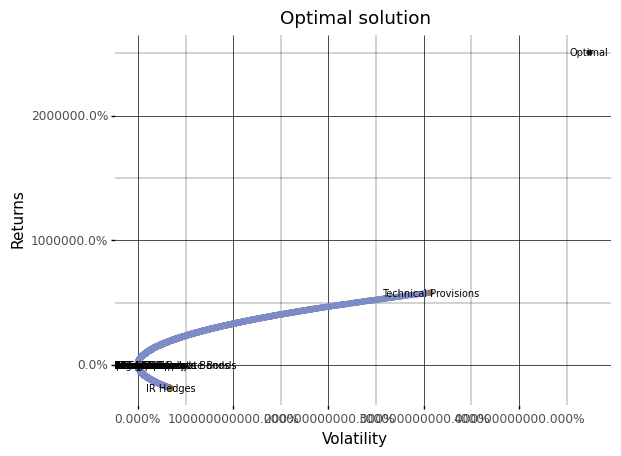

In [9]:
### 5) The Markowitz optimization

optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1)
for i, col in enumerate(asset_scenarios.columns):
  print("{}: {}".format(col, np.round(optimal.x[i],decimals = 0)))

c:\Python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Rates_up.png
c:\Python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Rates_down.png
c:\Python39\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Python39\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Eq_up.png


KeyboardInterrupt: 

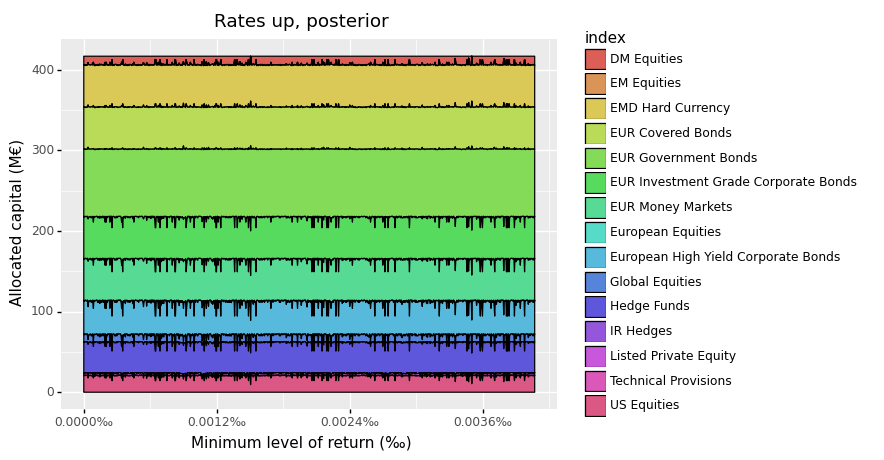

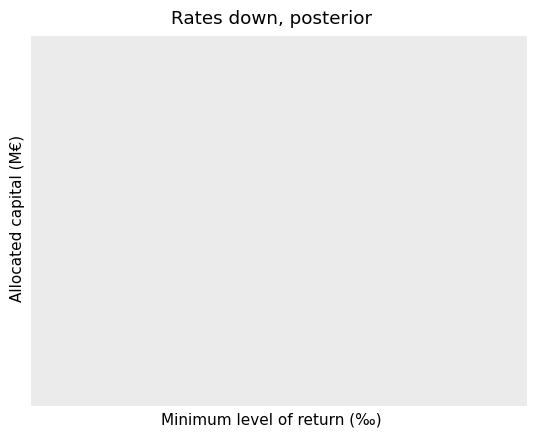

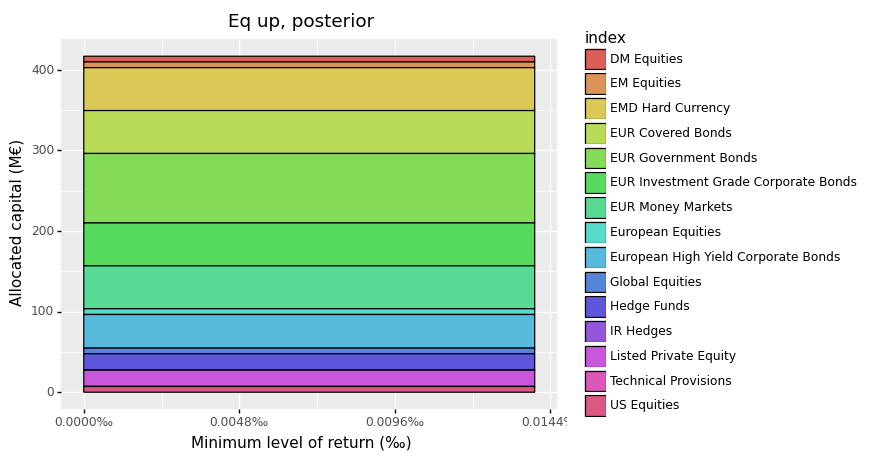

In [28]:
result_mu0 = pd.DataFrame(columns = range(8), index =['Result','Optimal risk', 'Expected return', *asset_names])

view_bar = range(len(titles))#tqdm(range(len(titles)), total=len(titles), desc=f"Views")
for k in view_bar:
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                        views_subsheet_name = k);
  precision = 1000
  precision_bar = range(precision)#tqdm(range(precision), total=precision, desc=f"Precision")
  result = pd.DataFrame(columns = range(precision), index =['Result','Optimal risk', 'Expected return', *asset_names])
  for i in precision_bar:
    p = np.array(prior)
    m = p.shape
    mu, _ = markoviz_optimizer.mean_and_var(asset_scenarios, posterior)
    mu_0_temp = np.linspace(start = 0, stop = np.max(mu), num = precision)
    ind_to_mu_0 = (np.abs(mu_0_temp - mu_0)).argmin()
    posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
    weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
    optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                           weighted_posterior,
                                           mu_0 = mu_0_temp[i],
                                           manual_constraints = manual_constraints,
                                           visualize = False,
                                           verbose = 0)
    if optimal.success == False:
      ind_to_mu_0 = ind_to_mu_0 if ind_to_mu_0 >= i else i
      break
    probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
    mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
    result.iloc[0,i] = optimal.success
    if optimal.success:
      result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
      result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
      result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
    
  result.columns = mu_0_temp
  #result.drop(index = ["IR Hedges", "Technical Provisions"], inplace=True)
  result.dropna(axis=1, how='all', inplace=True)
  melted= result.iloc[3:,:].melt(ignore_index=False).reset_index()
  melted = melted.astype({"value": float})
  melted.value /= 1000000

  plot = (ggplot(data = melted, mapping =  aes( x='variable', fill='index', y='value')) 
          + geom_area(colour = "black")
          + labs(title=f"{titles[k]}, posterior", y="Allocated capital (M€)", x="Minimum level of return (‰)")
          + scale_x_continuous(labels=lambda l: ["%.4f‰" % (v/total_capital * 1000) for v in l])
          )
  plot.draw();
  filename = f'stacked_{"_".join(titles[k].split(" "))}'
  plot.save(f'plots/{filename}.{file_extension}');

In [29]:
result.iloc[:,ind_to_mu_0]

Result                                  NaN
Optimal risk                            NaN
Expected return                         NaN
Global Equities                         NaN
DM Equities                             NaN
EM Equities                             NaN
European Equities                       NaN
US Equities                             NaN
EUR Money Markets                       NaN
EUR Government Bonds                    NaN
EUR Covered Bonds                       NaN
EUR Investment Grade Corporate Bonds    NaN
European High Yield Corporate Bonds     NaN
EMD Hard Currency                       NaN
Hedge Funds                             NaN
Listed Private Equity                   NaN
Technical Provisions                    NaN
IR Hedges                               NaN
Name: 999, dtype: object